# Start by loading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from scipy.stats import multivariate_normal
import seaborn as sns
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
mp.rc('text', usetex=True)
%matplotlib inline

In [11]:
#LOAD DATA
chi2_array_ALL_DATA_25k = np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/local/ALL_DATA_25k/chi2_array_ALL_DATA_25k.npy')
MVN_25k_MASTER = np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/MVN_25k_MASTER.npy')
COV_MASTER= np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/COV_MASTER.npy')
params_MASTER= np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/params_MASTER.npy')

<AxesSubplot:>

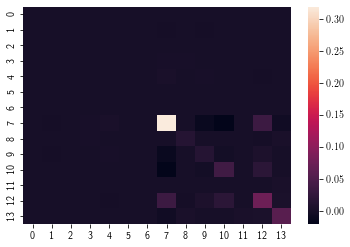

In [12]:
sns.heatmap(COV_MASTER)

In [ ]:
plt.hist(chi2_array_ALL_DATA_25k); plt.title'(

We see that this multivariate normal is a 2d array of size $N_{samples}\times N_{parameters}$ where above $N_{samples}=25,000, \ N_{parameters}=14$. But we want the multivariate gaussinan as a single number for each parameter set (for each point), since for a vector $z$, the multivariate normal is 
$$f(z ; \mu, \Sigma)=(2 \pi)^{-\left(\frac{N}{2}\right)} \operatorname{det}(\Sigma)^{-\frac{1}{2}} \exp \left(-.5(z-\mu)^{T} \Sigma^{-1}(z-\mu)\right)$$

$\chi^2$ value is expected to be around $~N_{DOF} = 4000-14$

If we do the same method of calculating the weights we run into this problem of getting zeros for the weights since the $\chi^2$ values are really large. But recall that the weights are 

$$w_k^i = \frac{L(\theta)}{L'(\theta)} = \frac{N_{samples} exp^{-\frac{1}{2} (\chi_k ^2 - E[\chi^2])}}{\mathcal{N}(\theta_i;\mu_i, \sigma_i) \ \sum_{k=1}^{N_{samples}} w_k}$$

### clearly, the old method of calculating the weights does not work anymore, because the $\chi^2$ values are too large now so we cannot exponentiate them, hence we have to work in the log space.

And we don't care about the overall large constant that is multiplying all the weights, we only care about the differences in weights between the data points. Therefore we can take the log of both sides

$$log w_k^i = log \frac{L(\theta)}{L'(\theta)} = log L(\theta) - log L'(\theta) = log [N_{samples} exp^{-\frac{1}{2} (\chi_k ^2 - E[\chi^2])} ] - log[ \mathcal{N}(\theta_i;\mu_i, \sigma_i) \ \sum_{k=1}^{N_{samples}} w_k] \ \ \ \ \ \ (1)$$

$log w = -\frac{1}{2} [\chi^2 - (z-\mu)^{T} \Sigma^{-1}(z-\mu) ]$

Define 

second term = $(z-\mu)^{T} \Sigma^{-1}(z-\mu)$

Text(0.5, 1.0, 'Second Term')

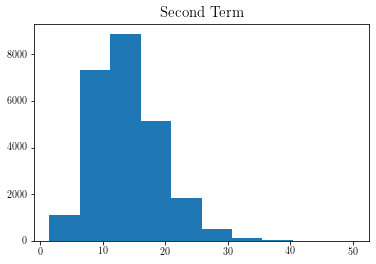

In [15]:
# z = MVN_per_point_l
mu = params_MASTER
sigma = COV_MASTER
second_term_l = []
for i in range(MVN_25k_MASTER.shape[0]):
    second_term = (MVN_25k_MASTER[i,:] - mu).T @ np.linalg.inv(sigma) @ (MVN_25k_MASTER[i,:] - mu)
    second_term_l.append(second_term)
plt.hist(np.array(second_term_l))# second term dist is much narrower, which is what we expect
plt.title('Second Term', fontsize=15)

Let's look at the $\chi^2$ distribution within $2\sigma$ around the best fit  values of the parameters.

In [37]:
list_of_tuples = []; 
MVG_within_1_sigma=[]
chi2_within_1_sigma=[] #np.empty((4000,14))
for i in range(14):
    param_list_i=[]
    chi2_list=[]
#     weight_list_i = []
    chi2_list_param_i=[]
    for k in range(4000):
        param_value = MVN_4000_MASTER[k, i] #at the kth point, for parameter i
        
        MVG_point_within_1s = MVN_per_point_l[k]
        #std = np.std(MVN_per_point_l)
        #mean_MVG = np.mean(MVN_per_point_l)
        
        std_MVN_value = np.std(MVN_4000_MASTER[:,i])
        mean_MVN_value = np.mean(MVN_4000_MASTER[:,i])
        if (param_value > (mean_MVN_value - 1*std_MVN_value)) and (param_value < (mean_MVN_value + 1*std_MVN_value)):
            #if weight_value < (mean_weight + 4*std_weight_value):

            #param_list_i.append(param_value)
            param_list_i.append(MVG_point_within_1s)
            chi2_list_param_i.append(chi2_array_ALL_DATA_25k[k])
    MVG_within_1_sigma.append(param_list_i)
    chi2_within_1_sigma.append(chi2_list_param_i)
            #chi2_within_1_sigma[k,i] = chi2_array_ALL_DATA_25k[k]
    tuple_i = (param_list_i, chi2_list)
    list_of_tuples.append(tuple_i)
#len(list_of_tuples)                
#list_of_tuples[1]

Same means of $\chi^2$ for each parameter, as we expect.

Still the weird behavior of the $\chi^2$ values being very large 

(array([2.4076e+04, 6.5000e+02, 1.6700e+02, 6.1000e+01, 2.7000e+01,
        1.0000e+01, 6.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.98516452e+06, 7.44368151e+15, 1.48873630e+16, 2.23310445e+16,
        2.97747260e+16, 3.72184075e+16, 4.46620890e+16, 5.21057705e+16,
        5.95494520e+16, 6.69931335e+16, 7.44368151e+16]),
 <BarContainer object of 10 artists>)

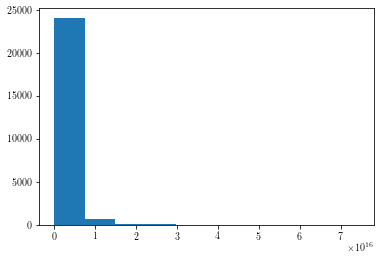

In [76]:
plt.hist(MVN_per_point_l)

# For all the following, two results are returned, the result using the expression and one from scipy, for comparison
The density function of multivariate normal distribution

In [16]:
def MVG(MVN, mu, sigma):
    """
    The density function of multivariate normal distribution.
    N = size of the mean vector, or number of parameter points (14)
    MVN = the 2D MV Gaussian for the sampling of the parameters 
    sigma = the covariance matrix from our best-fit values
    """

    MVN_per_point_l=[]; MVN_per_point_l_scipy=[]
    for i in range(MVN.shape[0]):
        # z is the vector of parameters
        z = MVN[i,:]


        N = z.size

        temp1 = np.linalg.det(sigma) ** (-1/2)
        temp2 = np.exp(-.5 * (z - mu).T @ np.linalg.inv(sigma) @ (z - mu))
        MVN_per_point = (2 * np.pi) ** (-N/2) * temp1 * temp2
        MVN_per_point_l.append(MVN_per_point)
        MVN_from_func = np.array(MVN_per_point_l)
        MVN_from_scipy = multivariate_normal.pdf(z, mu, sigma)
        MVN_per_point_l_scipy.append(MVN_from_scipy)
    return MVN_from_func, np.array(MVN_per_point_l_scipy)

$MVG(\hat{\theta}) = Gauss(x=\hat{theta}|\mu=\hat{\theta},\Sigma=\hat{\Sigma})$

In [18]:
def MVG_BestFit(MVN, mu, sigma):
    """
    The density function of multivariate normal distribution.
    N = size of the mean vector, or number of parameter points (14)
    MVN = the 2D MV Gaussian function
    sigma = the covariance matrix from our best-fit values
    """

#     MVN_per_point_l=[]

    #z = np.atleast_2d(z)
    z = MVN


    N = z.size

    temp1 = np.linalg.det(sigma) ** (-1/2)
    temp2 = np.exp(-.5 * (z - mu).T @ np.linalg.inv(sigma) @ (z - mu))
    MVN_per_point = (2 * np.pi) ** (-N/2) * temp1 * temp2
    
    MVN_per_point_scipy = multivariate_normal.pdf(z, mu, sigma)
    return np.array(MVN_per_point), MVN_per_point_scipy

In [20]:
#FLOAT 128 FOR HIGHER PRECISION
chi2_array_ALL_DATA_25k = chi2_array_ALL_DATA_25k.astype(np.float128)
MVN_25k_MASTER = MVN_25k_MASTER.astype(np.float128)

#EVALUAGE THE MV NORMAL AT EACH POINT (AT EACH SET OF PARAMETERS)
MVN_per_point_l, MVN_per_point_l_scipy = MVG(MVN_25k_MASTER, params_MASTER, COV_MASTER)
#EVALUAGE THE MV NORMAL AT THE BEST-FIT POINT
best_fitchi2_25k =3369.427
MVG_best_fit, MVG_best_fit_scipy = MVG_BestFit(params_MASTER, params_MASTER, COV_MASTER)

MVG Best fit =  1.557706340054779e+17 MVG Best fit from scipy =  1.5577063400260074e+17


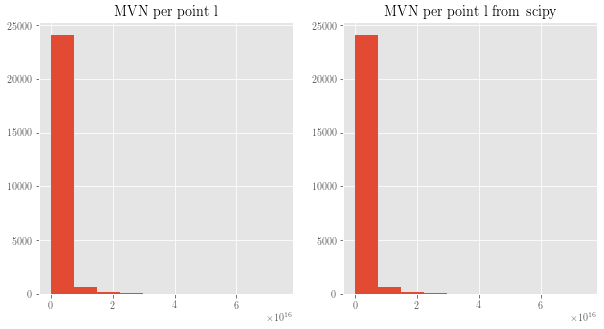

In [22]:
plt.style.use('ggplot')
plt.rcParams['text.usetex'] = True

fix, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].hist(MVN_per_point_l, label = 'MVN_per_point_l')
axs[1].hist(MVN_per_point_l_scipy, label='MVN_per_point_l_scipy')
axs[0].set_title('MVN per point l')
axs[1].set_title('MVN per point l from scipy')
print('MVG Best fit = ', MVG_best_fit, 'MVG Best fit from scipy = ', MVG_best_fit_scipy)
        

The analytical form and the form from scipy agree.

In [ ]:
plt.hist(chi2_array_ALL_DATA_25k/best_fitchi2_25k)

In [129]:
MVN_per_point_l_diff_mean[MVN_per_point_l_diff_mean <0]

array([-1.09561510e+15, -1.21901412e+15, -1.12372138e+15, ...,
       -1.06514992e+15, -1.18991749e+15, -1.24937140e+15], dtype=float128)

Define functions that return $\Delta \chi^2$ and $\Delta MVG$ (I refer to the multivariate normal likelihood as MVG) 

In [23]:
def delta_mean(chi2_arr, MVG_arr):
    mean_chi2 = chi2_arr - np.mean(chi2_arr)
    mean_MVG = MVG_arr - np.mean(MVG_arr)

    return mean_chi2, mean_MVG

def delta_best_fit(chi2_arr, MVG_arr):
    delta_chi2 = chi2_arr - best_fitchi2_25k
    delta_MVG = MVG_arr - MVG_best_fit
    return delta_chi2, delta_MVG

def pos_log_mask(chi2_arr, MVG_arr):
    mask = MVG_arr > 0
    pos_MVG = MVG_arr[MVG_arr > 0]
    pos_chi2 = chi2_arr[MVG_arr >0]
    return pos_chi2, pos_MVG, mask

def calc_weight_from_log(chi2_arr, MVG_arr):
    log_weight_unnormalized = (-0.5 * chi2_arr) - (np.log(MVG_arr))
    #delta_log_weight_unnormalized = log_weight_unnormalized - np.mean(log_weight_unnormalized)
    delta_log_weight_unnormalized = log_weight_unnormalized 
    weight_unnormalized = np.exp(delta_log_weight_unnormalized)
    weight_normalized = weight_unnormalized.size * weight_unnormalized/np.sum(weight_unnormalized)
    return weight_normalized

def calc_weight_normally(chi2_arr, MVG_arr):
    w = np.exp(-0.5 * chi2_arr)/MVG_arr
    
    w_norm = w.size * w/np.sum(w)
    return w_norm

$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})} = $ -0.00037585451045278400972 -0.0003758545104368198646


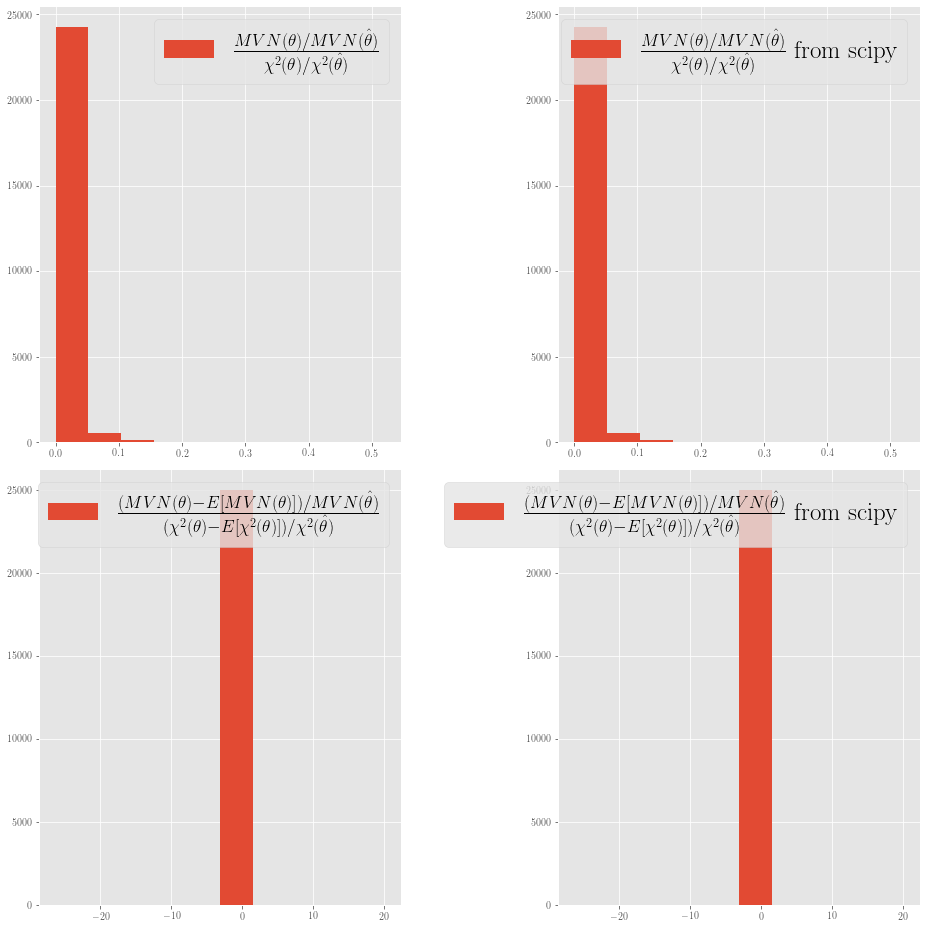

In [26]:
m=MVN_per_point_l/MVG_best_fit 
n=chi2_array_ALL_DATA_25k/best_fitchi2_25k #BEST FIT

m_scipy = MVN_per_point_l_scipy/MVG_best_fit_scipy

chi2_minus_mean, MVG_minus_mean = delta_mean(chi2_array_ALL_DATA_25k, MVN_per_point_l)

m_minus_mean = MVG_minus_mean/MVG_best_fit
n_minus_mean = chi2_minus_mean/best_fitchi2_25k

chi2_minus_mean, MVG_minus_mean_scipy = delta_mean(chi2_array_ALL_DATA_25k, MVN_per_point_l_scipy)
m_minus_mean_scipy = MVG_minus_mean_scipy/MVG_best_fit_scipy

fig, axs = plt.subplots(2,2, figsize=(13,13))

axs[0,0].hist(m/n, label=r'$\frac{MVN(\theta)/MVN(\hat{\theta})}{\chi^2(\theta)/\chi^2(\hat{\theta})}$')
axs[0,1].hist(m_scipy/n, label=r'$\frac{MVN(\theta)/MVN(\hat{\theta})}{\chi^2(\theta)/\chi^2(\hat{\theta})}$ from scipy')
axs[1,0].hist(m_minus_mean/n_minus_mean, label=r'$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})}$')
axs[1,1].hist(m_minus_mean_scipy/n_minus_mean, label=r'$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})}$ from scipy')

print(r'$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})} = $',np.mean(m_minus_mean/n_minus_mean), np.mean(m_minus_mean_scipy/n_minus_mean))
for i in range(2):
    for j in range(2):
        axs[i,j].legend(fontsize=25)
plt.tight_layout()

$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})} = $ -0.00037585451045278400972 -0.0003758545104368198646


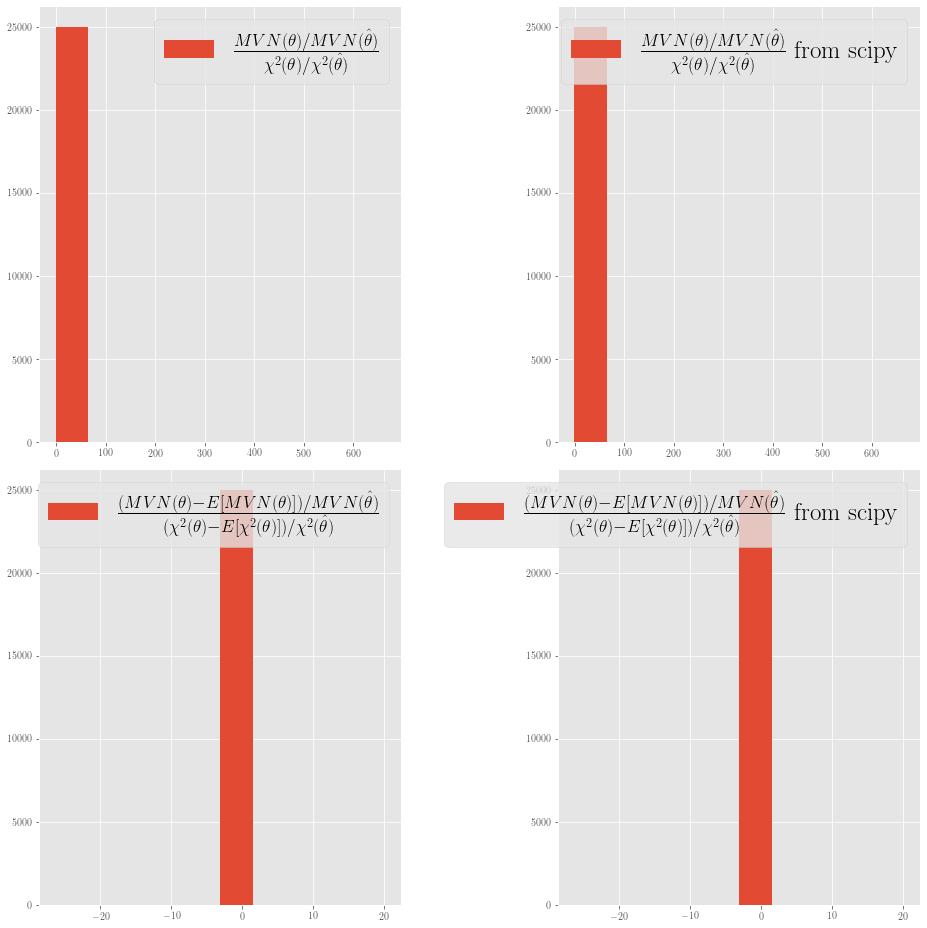

In [27]:
m=MVN_per_point_l/MVG_best_fit
n=chi2_array_ALL_DATA_25k - best_fitchi2_25k #BEST FIT

m_scipy = MVN_per_point_l_scipy/MVG_best_fit_scipy

chi2_minus_mean, MVG_minus_mean = delta_mean(chi2_array_ALL_DATA_25k, MVN_per_point_l)

m_minus_mean = MVG_minus_mean/MVG_best_fit
n_minus_mean = chi2_minus_mean/best_fitchi2_25k

chi2_minus_mean, MVG_minus_mean_scipy = delta_mean(chi2_array_ALL_DATA_25k, MVN_per_point_l_scipy)
m_minus_mean_scipy = MVG_minus_mean_scipy/MVG_best_fit_scipy

fig, axs = plt.subplots(2,2, figsize=(13,13))

axs[0,0].hist(m/n, label=r'$\frac{MVN(\theta)/MVN(\hat{\theta})}{\chi^2(\theta)/\chi^2(\hat{\theta})}$')
axs[0,1].hist(m_scipy/n, label=r'$\frac{MVN(\theta)/MVN(\hat{\theta})}{\chi^2(\theta)/\chi^2(\hat{\theta})}$ from scipy')
axs[1,0].hist(m_minus_mean/n_minus_mean, label=r'$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})}$')
axs[1,1].hist(m_minus_mean_scipy/n_minus_mean, label=r'$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})}$ from scipy')

print(r'$\frac{(MVN(\theta) - E \left[MVN(\theta)\right])/MVN(\hat{\theta})}{(\chi^2(\theta)-E[\chi^2(\theta)])/\chi^2(\hat{\theta})} = $',np.mean(m_minus_mean/n_minus_mean), np.mean(m_minus_mean_scipy/n_minus_mean))
for i in range(2):
    for j in range(2):
        axs[i,j].legend(fontsize=25)
plt.tight_layout()

(array([2.4999e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0.        ,  2497.41701771,  4994.83403541,  7492.25105312,
         9989.66807083, 12487.08508854, 14984.50210624, 17481.91912395,
        19979.33614166, 22476.75315937, 24974.17017707], dtype=float128),
 <BarContainer object of 10 artists>)

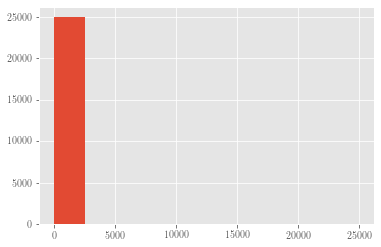

In [28]:
MVG_over_MVG_best_fit = MVN_per_point_l/MVG_best_fit
delta_chi2 = chi2_array_ALL_DATA_25k - best_fitchi2_25k

weight = np.exp(-0.5 * delta_chi2)/MVG_over_MVG_best_fit

weight = weight.shape[0]* weight/np.sum(weight)
plt.hist(weight)

In [29]:
np.mean(weight)

0.99999999999999999995

(array([2.50000000e+04, 1.61470837e-12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.01130691, 0.02295982, 0.03461273, 0.04626565, 0.05791856,
        0.06957147, 0.08122439, 0.0928773 , 0.10453022, 0.11618313,
        0.12783604], dtype=float128),
 <BarContainer object of 10 artists>)

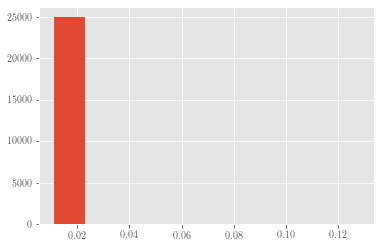

In [30]:
plt.hist(MVN_25k_MASTER[:,1], weights=weight)

(array([2.4998e+04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-3.17449028e+00,  2.36332688e+03,  4.72982824e+03,  7.09632961e+03,
         9.46283097e+03,  1.18293323e+04,  1.41958337e+04,  1.65623351e+04,
         1.89288364e+04,  2.12953378e+04,  2.36618392e+04], dtype=float128),
 <BarContainer object of 10 artists>)

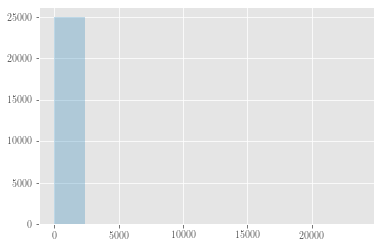

In [31]:
MVG_corrected = MVG_minus_mean_scipy/MVG_best_fit_scipy
chi2_corrected = chi2_minus_mean/best_fitchi2_25k
plt.hist(MVG_corrected, label='MVG_corrected', alpha=0.3)
plt.hist(chi2_corrected, label='chi2_corrected',alpha=0.3)

In [32]:
np.mean(MVG_corrected), np.mean(chi2_corrected)

(-6.339373470609644e-19, -3.5527136788005009294e-19)

In [33]:
weight = np.exp(-0.5*chi2_corrected)/abs(MVG_corrected)

(array([2.4998e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0.        ,  370.27934179,  740.55868358, 1110.83802538,
        1481.11736717, 1851.39670896, 2221.67605075, 2591.95539254,
        2962.23473433, 3332.51407613, 3702.79341792], dtype=float128),
 <BarContainer object of 10 artists>)

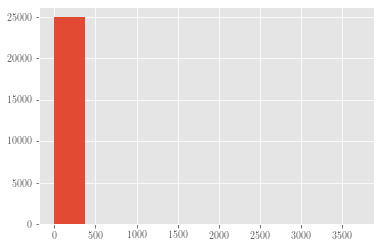

In [34]:
weight_normalized = MVG_corrected.shape[0] * weight/np.sum(weight)
plt.hist(weight_normalized)

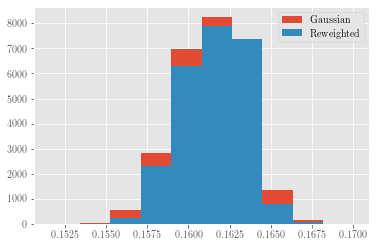

In [35]:
plt.hist(MVN_25k_MASTER[:,0], label='Gaussian')
plt.hist(MVN_25k_MASTER[:,0], weights=weight_normalized, label='Reweighted')
plt.legend()

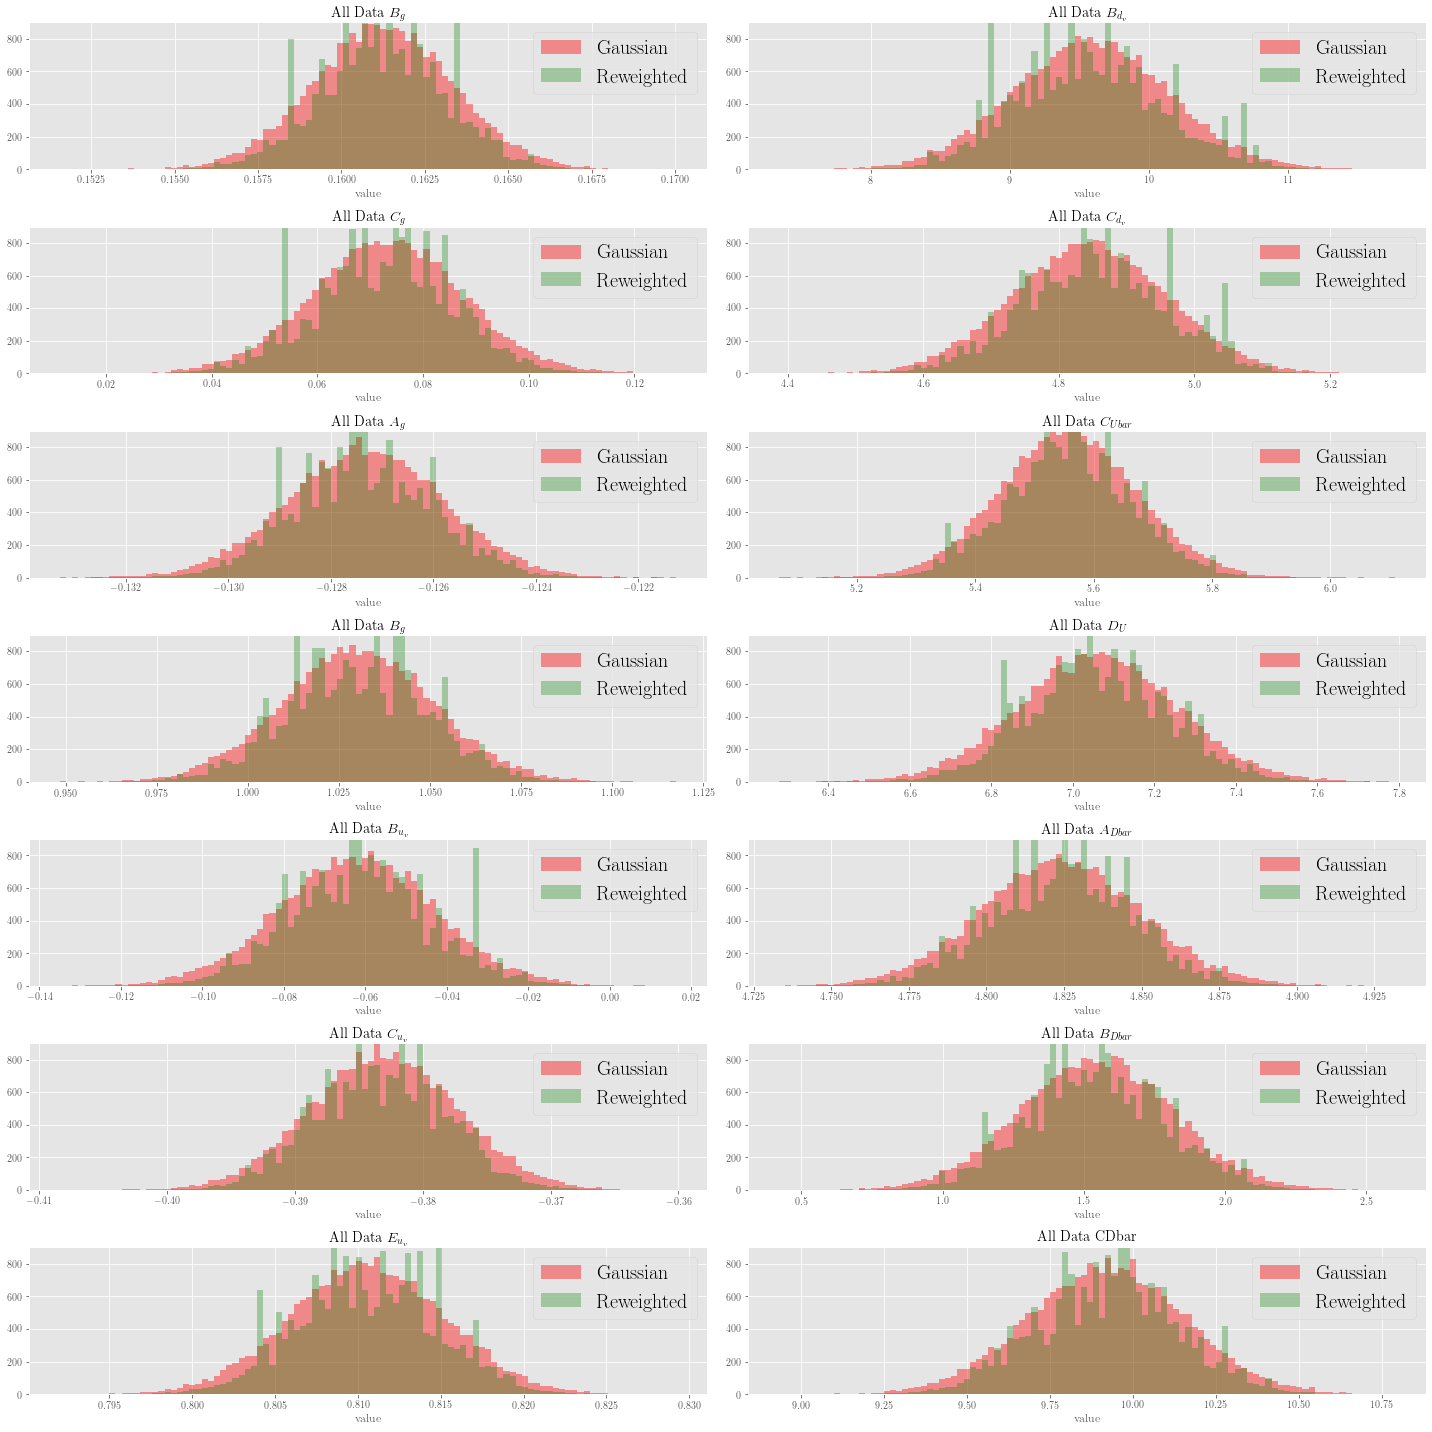

In [36]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,20))

titles = ['$B_g$','$C_g$','$A_g$','$B_g$','$B_{u_v}$','$C_{u_v}$','$E_{u_v}$','$B_{d_v}$','$C_{d_v}$','$C_{Ubar}$','$D_U$','$A_{Dbar}$','$B_{Dbar}$','CDbar','CDbar','CDbar','CDbar']

for i in range(7):
    axes[i,0].hist(MVN_25k_MASTER[:,i].flatten(), bins=100, color = 'r', alpha=0.4,label='Gaussian')
    axes[i,0].hist(MVN_25k_MASTER[:,i].flatten(), weights=weight_normalized, bins=100, color = 'g',alpha=0.3, label='Reweighted')
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[i,0].set_title('All Data '+ titles[i] )
    axes[i,0].set_xlabel('value')
    axes[i,0].set_ylim(0,900)
    axes[i,0].legend(fontsize=20)
for j in range(0,7):
    axes[j,1].hist(MVN_25k_MASTER[:,j+7].flatten(), bins=100, color = 'r', alpha=0.4,label='Gaussian')
    axes[j,1].hist(MVN_25k_MASTER[:,j+7].flatten(), weights=weight_normalized, bins=100, color = 'g',alpha=0.3, label='Reweighted')
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[j,1].set_title('All Data ' +titles[j+7] )
    axes[j,1].set_xlabel('value')
    axes[j,1].set_ylim(0,900)
    axes[j,1].legend(fontsize=20)
    
plt.tight_layout()
plt.show()

density from which we sample should have longer tails than the true likelihood. Naivly, the function that we sample from should be roughly. 

In [37]:
mask1=  (weight_normalized > (weight_normalized.mean() - 2*weight_normalized.std())) #and (weight_normalized < (weight_normalized.mean() + 2*weight_normalized.std())).all()
mask2= (weight_normalized < (weight_normalized.mean() + 2*weight_normalized.std()))
filtered_weights=weight_normalized[mask1][mask2]
print(filtered_weights.shape, weight_normalized.mean(), weight_normalized.std())

(24964,) 0.99999999999999999995 24.152791480396143016


In [124]:


def filter_within_bestfit(chi2_arr, MVG_arr, MVN_sample):
    

    MVG_within_1_sigma=[]
    chi2_within_1_sigma=[]   
    MVN_within_1_sigma = []
    
    for i in range(14):
        MVG_list=[]
        chi2_list=[]
        
        MVN_param_i = []
        for k in range(MVN_sample.shape[0]):
            param_value = MVN_sample[k, i]#sample parameter value of MVN 
            MVG_at_k = MVG_arr[k]
            chi2_at_k = chi2_arr[k]
            
            std_MVN_value = np.std(MVN_sample[:,i])#for all the k's (number of points, at parameter label i
            mean_MVN_value = np.mean(MVN_sample[:,i])
            
            if (param_value > (mean_MVN_value - 2*std_MVN_value)) and (param_value < (mean_MVN_value + 2*std_MVN_value)):
                MVG_list.append(MVG_at_k)
                chi2_list.append(chi2_at_k)
                
                MVN_param_i.append(param_value)
                
        MVN_within_1_sigma.append(np.array(MVN_param_i))
                
        MVG_within_1_sigma.append(np.array(MVG_list))
        chi2_within_1_sigma.append(np.array(chi2_list))
    
    return np.array(chi2_within_1_sigma), np.array(MVG_within_1_sigma), np.array(MVN_within_1_sigma)


        
chi2_within_1_sigma, MVG_within_1_sigma, MVN_within_1_sigma = filter_within_bestfit(chi2_corrected, MVG_corrected, MVN_25k_MASTER)
                                   
# chi2_within_1_sigma=[] #np.empty((25k,14))
# for i in range(14):
#     param_list_i=[]
#     chi2_list=[]
# #     weight_list_i = []
#     chi2_list_param_i=[]
#     for k in range(25k):
#         param_value = MVN_25k_MASTER[k, i] #at the kth point, for parameter i
        
#         MVG_point_within_1s = MVN_per_point_l[k]
#         #std = np.std(MVN_per_point_l)
#         #mean_MVG = np.mean(MVN_per_point_l)
        
#         std_MVN_value = np.std(MVN_25k_MASTER[:,i])
#         mean_MVN_value = np.mean(MVN_25k_MASTER[:,i])
#         if (param_value > (mean_MVN_value - 1*std_MVN_value)) and (param_value < (mean_MVN_value + 1*std_MVN_value)):
#             #if weight_value < (mean_weight + 4*std_weight_value):

#             #param_list_i.append(param_value)
#             param_list_i.append(MVG_point_within_1s)
#             chi2_list_param_i.append(chi2_array_ALL_DATA_25k[k])
#     MVG_within_1_sigma.append(param_list_i)
#     chi2_within_1_sigma.append(chi2_list_param_i)
#             #chi2_within_1_sigma[k,i] = chi2_array_ALL_DATA_25k[k]
#     tuple_i = (param_list_i, chi2_list)
#     list_of_tuples.append(tuple_i)
#len(list_of_tuples)                
#list_of_tuples[1]

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [129]:
MVG_within_1_sigma.shape
chi2_within_1_sigma

array([array([-2.90022406e+00, -2.50865791e+00,  4.11865664e+00, ...,
              -1.59890741e+00, -3.81138043e-04, -2.83872884e+00], dtype=float128),
       array([-2.90022406e+00, -2.50865791e+00,  4.11865664e+00, ...,
              -2.33656272e+00, -1.59890741e+00, -3.81138043e-04], dtype=float128),
       array([-2.90022406e+00, -2.50865791e+00,  4.11865664e+00, ...,
              -1.59890741e+00, -3.81138043e-04, -2.83872884e+00], dtype=float128),
       array([-2.90022406e+00, -2.50865791e+00,  4.11865664e+00, ...,
              -1.59890741e+00, -3.81138043e-04, -2.83872884e+00], dtype=float128),
       array([-2.90022406e+00, -2.50865791e+00,  4.11865664e+00, ...,
              -2.33656272e+00, -1.59890741e+00, -3.81138043e-04], dtype=float128),
       array([-2.90022406e+00, -2.50865791e+00,  4.11865664e+00, ...,
              -1.59890741e+00, -3.81138043e-04, -2.83872884e+00], dtype=float128),
       array([-2.90022406e+00,  4.11865664e+00, -2.82315874e+00, ...,
            

In [128]:
weight_within_1s = np.exp(-0.5*chi2_within_1_sigma)/abs(MVG_within_1_sigma)
weight_within_1s = weight_within_1s.shape[0] * weight_within_1s/np.sum(weight_within_1s)
plt.hist(weight_within_1s, label=r'weight within $2 \ \sigma$')

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable exp method

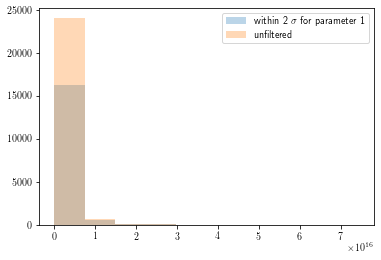

In [289]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,20))

titles = ['$B_g$','$C_g$','$A_g$','$B_g$','$B_{u_v}$','$C_{u_v}$','$E_{u_v}$','$B_{d_v}$','$C_{d_v}$','$C_{Ubar}$','$D_U$','$A_{Dbar}$','$B_{Dbar}$','CDbar','CDbar','CDbar','CDbar']

for i in range(7):
    axes[i,0].hist(MVN_within_1_sigma[i], bins=100, color = 'r', alpha=0.4,label='Gaussian')
    axes[i,0].hist(MVN_within_1_sigma[i], weights=weight_within_1s, bins=100, color = 'g',alpha=0.3, label='Reweighted')
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[i,0].set_title('All Data '+ titles[i] )
    axes[i,0].set_xlabel('value')
    axes[i,0].set_ylim(0,900)
    axes[i,0].legend(fontsize=20)
for j in range(0,7):
    axes[j,1].hist(MVN_within_1_sigma[i+7], bins=100, color = 'r', alpha=0.4,label='Gaussian')
    axes[j,1].hist(MVN_25k_MASTER[:,j+7].flatten(), weights=weight_within_1s, bins=100, color = 'g',alpha=0.3, label='Reweighted')
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[j,1].set_title('All Data ' +titles[j+7] )
    axes[j,1].set_xlabel('value')
    axes[j,1].set_ylim(0,900)
    axes[j,1].legend(fontsize=20)
    
plt.tight_layout()
plt.show()

(array([1.7081e+04, 5.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.07398702e+03, 1.99167585e+06, 3.98127771e+06, 5.97087957e+06,
        7.96048143e+06, 9.95008329e+06, 1.19396851e+07, 1.39292870e+07,
        1.59188889e+07, 1.79084907e+07, 1.98980926e+07], dtype=float128),
 <BarContainer object of 10 artists>)

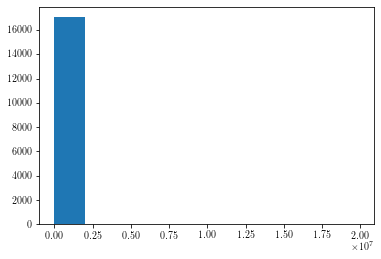

In [290]:
plt.hist(chi2_within_1_sigma[2])

1.0


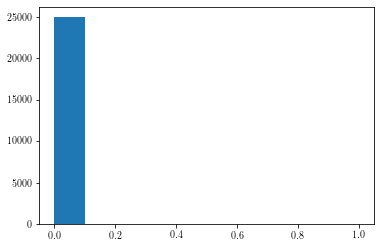

In [324]:


def MVG_BestFit(MVN, mu, sigma):
    """
    The density function of multivariate normal distribution.
    N = size of the mean vector, or number of parameter points (14)
    MVN = the 2D MV Gaussian function
    sigma = the covariance matrix from our best-fit values
    """

    z = MVN
    N = z.size

    temp1 = np.linalg.det(sigma) ** (-1/2)
    temp2 = np.exp(-.5 * (z - mu).T @ np.linalg.inv(sigma) @ (z - mu))
    MVN_per_point = (2 * np.pi) ** (-N/2) * temp1 * temp2

    return MVN_per_point

best_fitchi2_25k =3369.427
MVG_best_fit = MVG_BestFit(params_MASTER, params_MASTER, COV_MASTER)

MVN_per_point_l = f(MVN_25k_MASTER, params_MASTER, COV_MASTER)

def delta_mean(chi2_arr, MVG_arr):
    mean_chi2 = chi2_arr - np.mean(chi2_arr)
    mean_MVG = MVG_arr - np.mean(MVG_arr)

    return mean_chi2, mean_MVG

def delta_best_fit(chi2_arr, MVG_arr):
    delta_chi2 = chi2_arr - best_fitchi2_25k
    delta_MVG = MVG_arr - MVG_best_fit
    return delta_chi2, delta_MVG

def pos_log_mask(chi2_arr, MVG_arr):
    mask = MVG_arr > 0
    pos_MVG = MVG_arr[MVG_arr > 0]
    pos_chi2 = chi2_arr[MVG_arr >0]
    return pos_chi2, pos_MVG, mask

def calc_weight_from_log(chi2_arr, MVG_arr):
    log_weight_unnormalized = (-0.5 * chi2_arr) - (np.log(MVG_arr))
    #delta_log_weight_unnormalized = log_weight_unnormalized - np.mean(log_weight_unnormalized)
    delta_log_weight_unnormalized = log_weight_unnormalized 
    weight_unnormalized = np.exp(delta_log_weight_unnormalized)
    weight_normalized = weight_unnormalized.size * weight_unnormalized/np.sum(weight_unnormalized)
    return weight_normalized

def calc_weight_normally(chi2_arr, MVG_arr):
    w = np.exp(-0.5 * chi2_arr)/MVG_arr
    
    w_norm = w.size * w/np.sum(w)
    return w_norm

chi, MVG = delta_mean(chi2_array_ALL_DATA_25k, MVN_per_point_l)

chi2, MVG2 = delta_best_fit(chi, MVG)

chi3, MVG3 = delta_best_fit(chi2_within_1_sigma[0], MVG_within_1_sigma[0])



#chi_pos, MVG_pos, mask = pos_log_mask(chi, MVG) #works

chi_pos, MVG_pos, mask = pos_log_mask(chi, MVG)

#chi_pos2, MVG_pos2, mask = pos_log_mask(chi2_within_1_sigma[0], MVG_within_1_sigma[0])

w = calc_weight_from_log(chi_pos, MVG_pos)

w_norm = calc_weight_normally(chi2, MVG2)
plt.hist(w_norm, range=(0,1))
print(w.mean())

In [325]:
w, w.size

(array([2.18946168e-221, 1.42761601e-371, 2.04382850e-849, ...,
        7.81585034e-401, 1.02308495e-124, 1.88397511e-137], dtype=float128),
 5442)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 23848 but corresponding boolean dimension is 23882

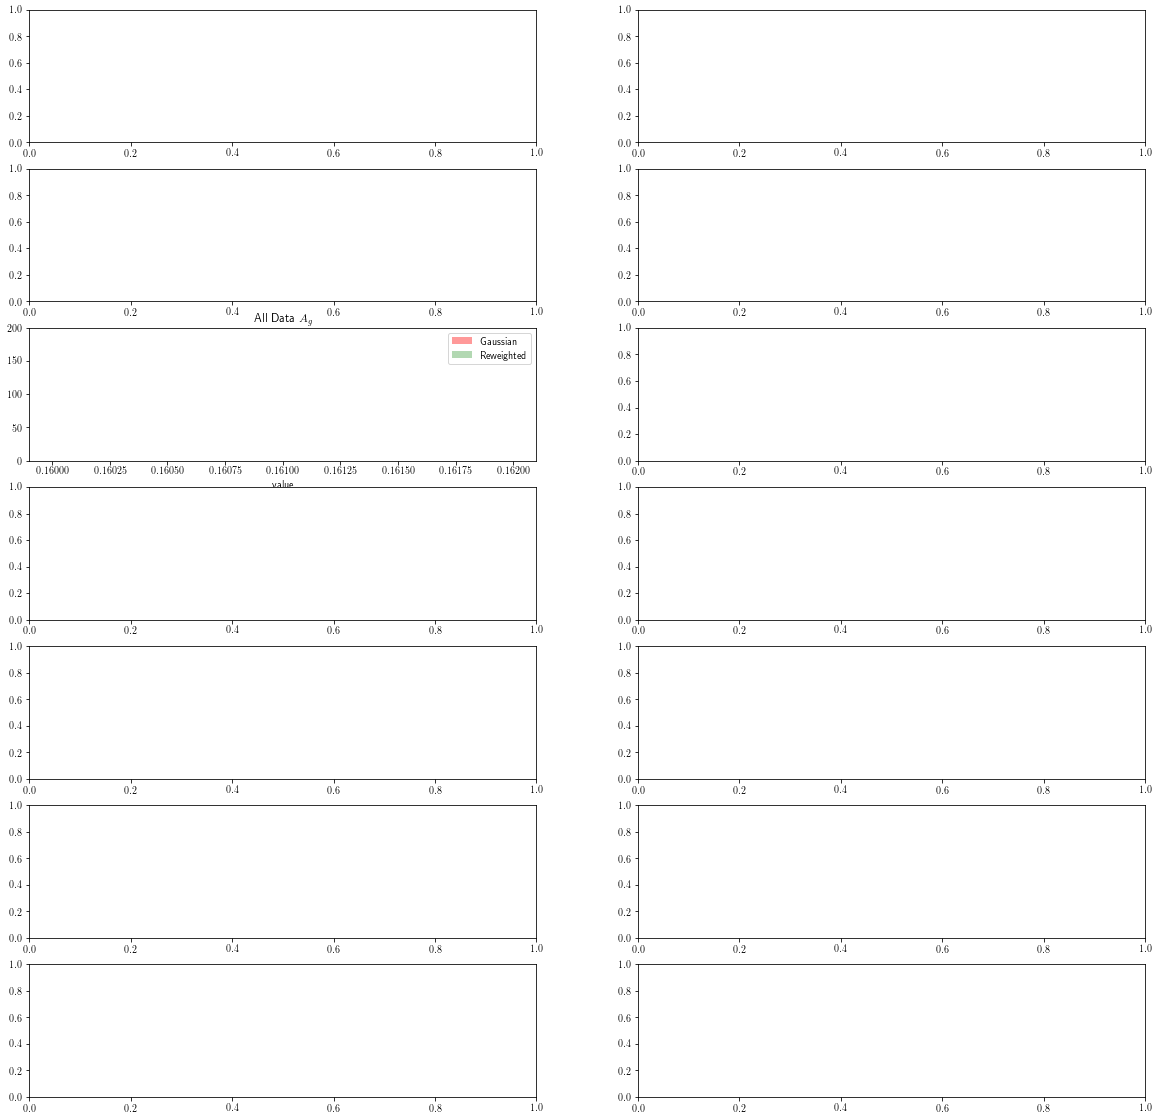

In [273]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,20))

titles = ['$B_g$','$C_g$','$A_g$','$B_g$','$B_{u_v}$','$C_{u_v}$','$E_{u_v}$','$B_{d_v}$','$C_{d_v}$','$C_{Ubar}$','$D_U$','$A_{Dbar}$','$B_{Dbar}$','CDbar','CDbar','CDbar','CDbar']


for i in range(7):
    axes[i,0].hist(MVN_within_1_sigma[i][mask], bins=100, color = 'r', alpha=0.4,label='Gaussian', range=(0.160,0.162))
    axes[i,0].hist(MVN_within_1_sigma[i][mask], weights=w, bins=100, color = 'g',alpha=0.3, label='Reweighted', range=(0.160,0.162))
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[i,0].set_title('All Data '+ titles[i] )
    axes[i,0].set_xlabel('value')
    axes[i,0].set_ylim(0,200)
    axes[i,0].legend()
for j in range(0,7):
    axes[j,1].hist(MVN_within_1_sigma[i][mask], bins=100, color = 'r', alpha=0.4,label='Gaussian', range=(0.160,0.162))
    axes[j,1].hist(MVN_within_1_sigma[i][mask], weights=w, bins=100, color = 'g',alpha=0.3, label='Reweighted', range=(0.160,0.162))
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[j,1].set_title('All Data ' +titles[j+7] )
    axes[j,1].set_xlabel('value')
    axes[j,1].set_ylim(0,200)
    axes[j,1].legend()
    
plt.tight_layout()
plt.show()

/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ali/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in longdouble_scalars
  ret = ret.dtype.type(ret / rcount)


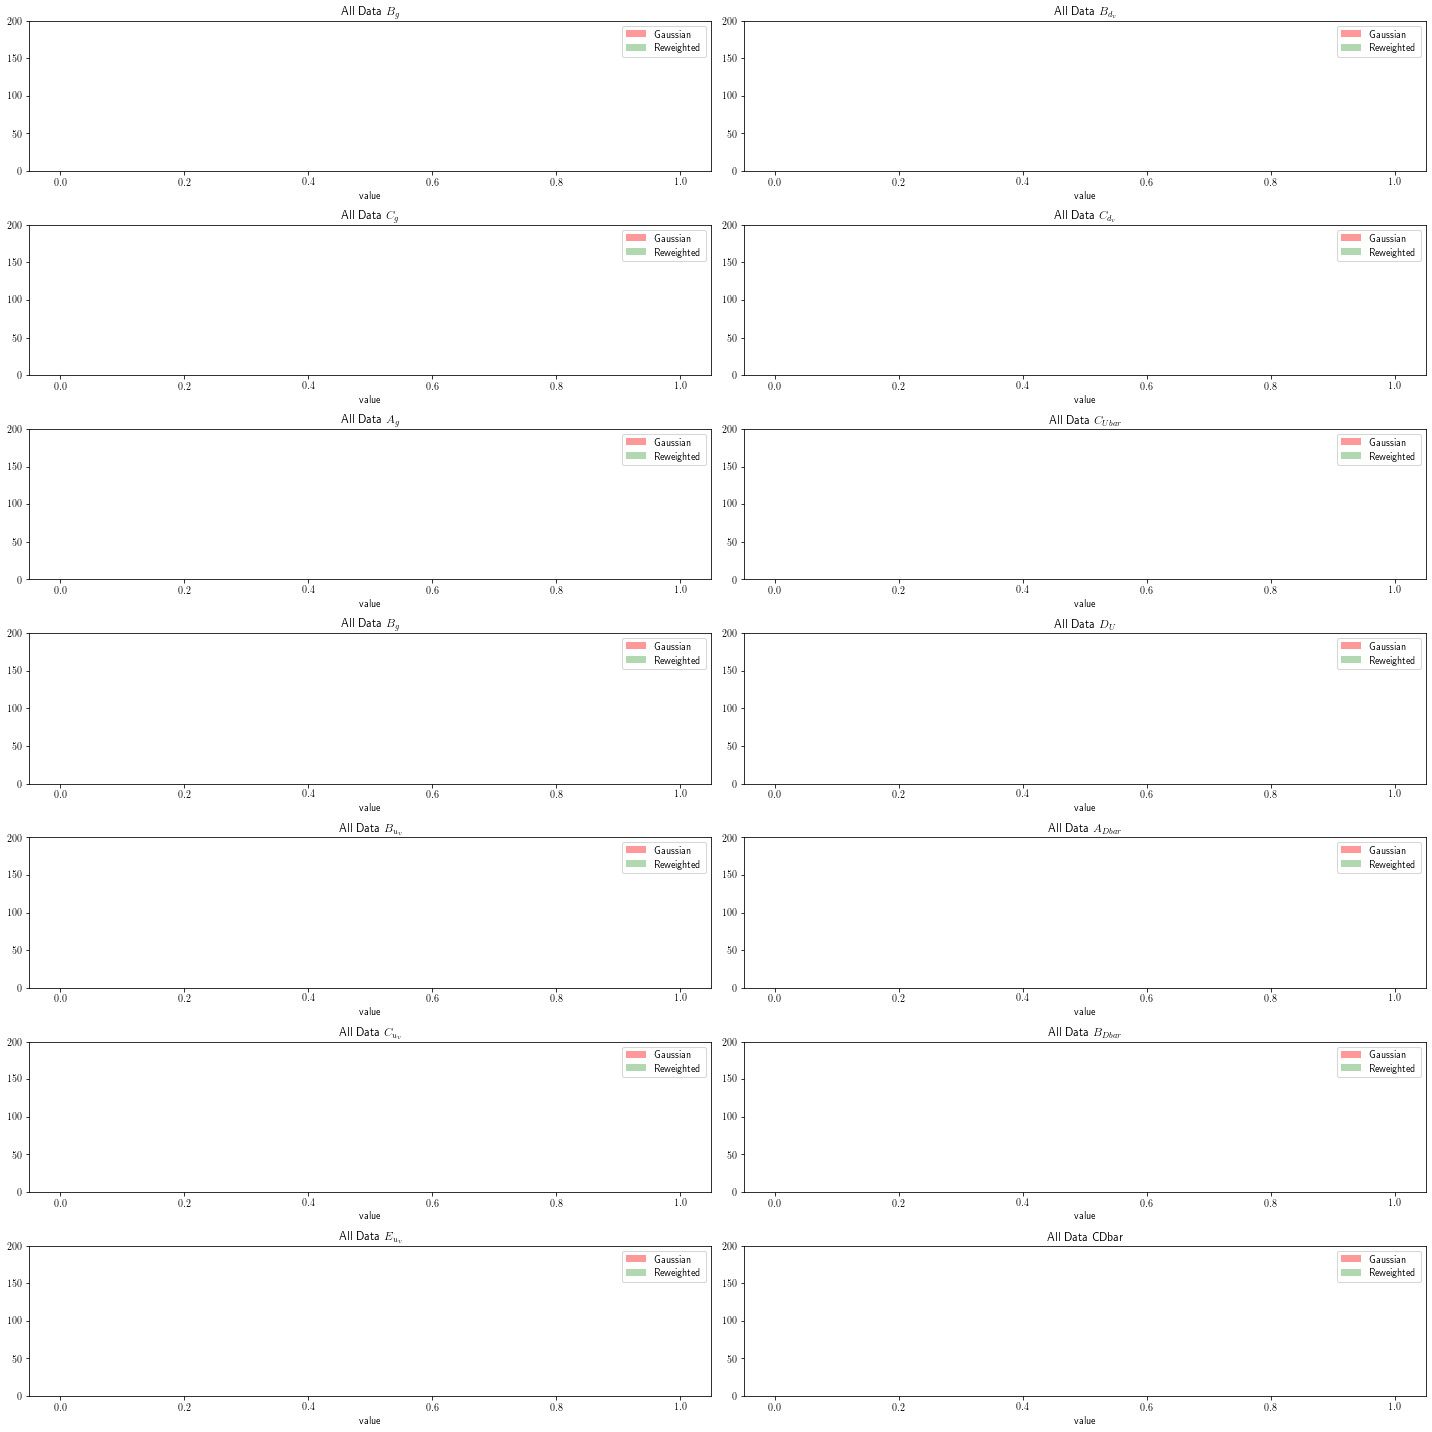

((0, 14), (0,))

In [193]:
chi2_array_ALL_DATA_25k = np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/local/ALL_DATA_25k/chi2_array_ALL_DATA_25k.npy')
MVN_25k_MASTER = np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/MVN_25k_MASTER.npy')
COV_MASTER= np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/COV_MASTER.npy')
params_MASTER= np.load('/home/ali/Desktop/Pulled_Github_Repositories/NNPDF_Uncertainty/master_version/samples/params_MASTER.npy')

chi2_array_ALL_DATA_25k = chi2_array_ALL_DATA_25k.astype(np.float128)
MVN_25k_MASTER = MVN_25k_MASTER.astype(np.float128)

best_fitchi2_25k =3369.427
MVG_best_fit = MVG_BestFit(params_MASTER, params_MASTER, COV_MASTER)

MVN_per_point_l = f(MVN_25k_MASTER, params_MASTER, COV_MASTER)


#first subtract the mean from both chi2 and MVG
# MVN_per_point_l_diff_mean = MVN_per_point_l - np.mean(MVN_per_point_l)

# pos_chi2_diff_mean =pos_chi2 - np.mean(pos_chi2)

# #now subtract best-fit values of chi2 and MVG
MVN_per_point_l_diff_mean = MVN_per_point_l - MVG_best_fit
pos_chi2_diff_mean = chi2_array_ALL_DATA_25k - best_fitchi2_25k

#HERE is where the positive masking should be done (right before taking the log)
MVN_per_point_l_diff_mean_pos = MVN_per_point_l_diff_mean[MVN_per_point_l_diff_mean > 0]
pos_chi2_diff_mean_pos = pos_chi2_diff_mean[MVN_per_point_l_diff_mean > 0]

#now calculate the log weight
log_weight_unnormalized = (-0.5 * pos_chi2_diff_mean_pos) - (np.log(MVN_per_point_l_diff_mean_pos))

log_weight_unnormalized = log_weight_unnormalized - np.mean(log_weight_unnormalized)
#exponentiate to get the weight
weight_unnormalized = np.exp(log_weight_unnormalized)
#normalize
weight_normalized = len(weight_unnormalized) * weight_unnormalized/np.sum(weight_unnormalized)


MVN_param_1_pos = MVN_25k_MASTER[:,][MVN_per_point_l_diff_mean > 0]

# plt.hist(MVN_param_1_pos, weights=weight_normalized, bins=50, label='Reweighted', alpha=0.3)
# plt.hist(MVN_param_1_pos, bins=50, label='Gaussian',  alpha=0.3)
# plt.ylim(0,5)
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,20))

titles = ['$B_g$','$C_g$','$A_g$','$B_g$','$B_{u_v}$','$C_{u_v}$','$E_{u_v}$','$B_{d_v}$','$C_{d_v}$','$C_{Ubar}$','$D_U$','$A_{Dbar}$','$B_{Dbar}$','CDbar','CDbar','CDbar','CDbar']


for i in range(7):
    axes[i,0].hist(MVN_25k_MASTER[:,i][MVN_per_point_l_diff_mean > 0], bins=100, color = 'r', alpha=0.4,label='Gaussian')
    axes[i,0].hist(MVN_25k_MASTER[:,i][MVN_per_point_l_diff_mean > 0], weights=weight_normalized, bins=100, color = 'g',alpha=0.3, label='Reweighted')
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[i,0].set_title('All Data '+ titles[i] )
    axes[i,0].set_xlabel('value')
    axes[i,0].set_ylim(0,200)
    axes[i,0].legend()
for j in range(0,7):
    axes[j,1].hist(MVN_25k_MASTER[:,i][MVN_per_point_l_diff_mean > 0], bins=100, color = 'r', alpha=0.4,label='Gaussian')
    axes[j,1].hist(MVN_25k_MASTER[:,i][MVN_per_point_l_diff_mean > 0], weights=weight_normalized, bins=100, color = 'g',alpha=0.3, label='Reweighted')
    #axes[i,1].set(title=titles[i] + ' Weighted', xlabel='value')
    axes[j,1].set_title('All Data ' +titles[j+7] )
    axes[j,1].set_xlabel('value')
    axes[j,1].set_ylim(0,200)
    axes[j,1].legend()
    
plt.tight_layout()
plt.show()


MVN_param_1_pos.shape, weight_normalized.shape

In [160]:
weight_normalized

4.0948151612105941448e-2181

/home/ali/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ali/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'weights')

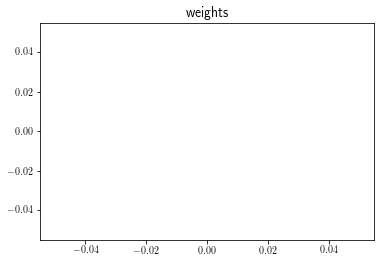

In [153]:
plt.hist(weight_normalized, density=True)
plt.title('weights', fontsize=14)

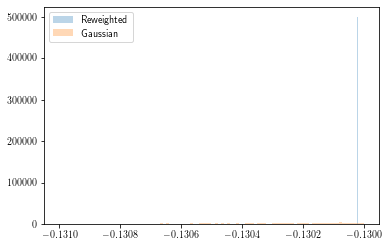

In [74]:


plt.hist(MVN_25k_MASTER[:,2], weights=weight_param_1, bins=100, label='Reweighted', alpha=0.3, density=True, range=(-0.1302,-0.130))
plt.hist(MVN_25k_MASTER[:,2], bins=100, label='Gaussian',  alpha=0.3, density=True, range=(-0.131,-0.130))
plt.legend()

In [33]:
np.mean(MVG_within_1_sigma[0]), np.mean(MVG_within_1_sigma[2]), np.mean(MVG_within_1_sigma[3])

(1594283065219208.0, 1559230864092711.5, 1556336458237995.5)

In [25]:
np.log(np.mean(MVG_within_1_sigma[0]))

35.0052005412063

(array([4.000e+00, 5.000e+01, 5.600e+02, 2.825e+03, 6.973e+03, 8.256e+03,
        4.789e+03, 1.366e+03, 1.660e+02, 1.100e+01]),
 array([0.15156416, 0.1534104 , 0.15525665, 0.15710289, 0.15894913,
        0.16079537, 0.16264161, 0.16448785, 0.1663341 , 0.16818034,
        0.17002658], dtype=float128),
 <BarContainer object of 10 artists>)

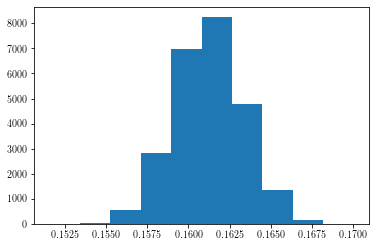

In [26]:
param_1 = MVN_25k_MASTER[:,0]
weight_1 = 
plt.hist(param_1)

Suppose we just have a 2D example. Suppose the entire parameterization is composed of two parameters $\vec{\theta} = \{ \theta_1, \theta_2 \}$. Suppose then we have two data points {point 1, point 2}. Then we have the best-fit values

$$\hat{\theta} = \{ \hat{\theta}_1, \hat{\theta}_2 \}$$
$$\hat{\Sigma} = \hat{\Sigma}_{2\times 2} $$

We then generate multivariate Gaussian sampling for the two data points using $\hat{\theta} $ and $\hat{\Sigma}$
$$\mathcal{N}_{sample} ( \vec{\mu} = \vec{\hat{\theta}}, \Sigma = \hat{\Sigma} )$$

And we use this as input to xfitter, so we get a $\chi^2$ value for each point (dataset k) $\chi^{2,k}$ and a single multivariate Gaussian point for the parameters at that point $\mathcal{N}_{\text{per point}}$ so that the multivariate Gaussian for the first point is 

$$ \mathcal{N}^{\text{point 1}} = \mathcal{N} \left( \vec{x} = \{ \theta_{sample, 1}^1, \theta_{sample , 2}^1 \} \ \big| \ \vec{\mu} = \hat{\vec{\theta}}, \Sigma = \hat{\Sigma} \right) $$

Hence we get a set of values for each data point. SO for the first data point, we have a associated
$$ D^1 = \left\{ \theta_{sample, 1}^1, \ \theta_{sample, 2}^1, \chi^{2,1}, \mathcal{N}^{\text{point 1}} \right\} $$

Hence the weight for the first point (data set) is 
$$ w^1 = \mathcal{A} \frac{ e^{-\frac{1}{2}  \chi^{2,1} }}{\mathcal{N}^{\text{point 1}} } $$
where $\mathcal{A}$ is a normalization constant.

We see here that there is huge dynamic range discrepancies between the numerator and the denomenator of the weight, and hence the weight values are not reasonable. Perhaps $\chi^2$ values are per dataset? 

Text(0.5, 1.0, '$\\chi^2$ values within $1\\ \\sigma$ of the best-fit values of the parameters')

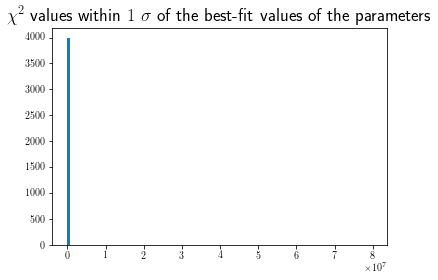

In [19]:
plt.hist(chi2_within_1_sigma[0], bins=100)
plt.title('$\chi^2$ values within $1\ \sigma$ of the best-fit values of the parameters', fontsize=18)

In [20]:
len(MVG_within_1_sigma), len(MVG_within_1_sigma[0])

(14, 4000)

Text(0.5, 1.0, 'MVG parameter values within $1\\ \\sigma$ of the best-fit values of the parameters')

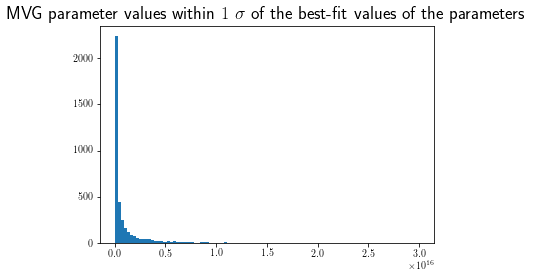

In [21]:
plt.hist(MVG_within_1_sigma[0], bins=100, range=(0,3e16))
plt.title('MVG parameter values within $1\ \sigma$ of the best-fit values of the parameters', fontsize=18)

Around the peak of the multivariate Gaussian, we expect this approximation to work and the $\chi^2$ values not to be so large.

In [22]:
chi2_array_ALL_DATA_25k - np.mean(chi2_array_ALL_DATA_25k)

array([-9.77209327e+03, -8.45273971e+03,  1.38775129e+04, ...,
       -5.38740181e+03, -1.28421681e+00, -9.56488961e+03], dtype=float128)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.4998e+04]),
 array([-3.98634065e+07, -3.58765294e+07, -3.18896524e+07, -2.79027753e+07,
        -2.39158983e+07, -1.99290212e+07, -1.59421442e+07, -1.19552671e+07,
        -7.96839007e+06, -3.98151302e+06,  5.36403151e+03], dtype=float128),
 <BarContainer object of 10 artists>)

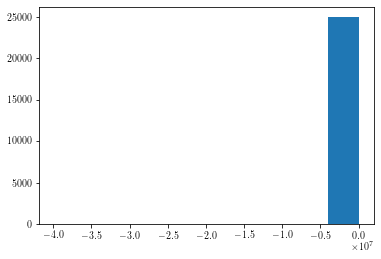

In [25]:
chi2_diff = chi2_array_ALL_DATA_25k - np.mean(chi2_array_ALL_DATA_25k)
w = -0.5*(chi2_diff-np.array(second_term_l))
plt.hist(w)

In [55]:
np.mean(chi2_diff)

-1.2732925824820995331e-14

In [18]:
mean_chi2 = np.mean(chi2_array_ALL_DATA_25k)
chi2_best_fit = 3369.427
#remember to rename diff (no need to take diff at this point)
# chi2_diff = chi2_array_ALL_DATA_25k - mean_chi2
chi2_diff = chi2_array_ALL_DATA_25k - chi2_best_fit

chi2_diff = chi2_diff - np.mean(chi2_diff)

log_numerator = -0.5*chi2_diff
log_numerator.shape
# for i in range(14):
#     log_numerator[:,i] =  - 0.5 * (chi2_diff)
# log_numerator #no normalization factor
log_numerator, np.mean(log_numerator)

(array([ 4.88604663e+03,  4.22636985e+03, -6.93875645e+03, ...,
         2.69370091e+03,  6.42108406e-01,  4.78244480e+03]),
 6.51925802230835e-13)

In [19]:
# log_numerator = log_numerator - np.mean(log_numerator)
# log_numerator

In [85]:
np.log(MVN_per_point_l)

array([35.32073269, 32.90517785, 32.81993112, ..., 34.87679871,
       30.89499864, 28.34919446])

### Remember (from above)

#### log numerator $ = -\frac{1}{2} \chi^2 (\vec{\theta_i} )$,  log denomenator $=log [MVG(\vec{\theta_i})]$

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'log denomenator')

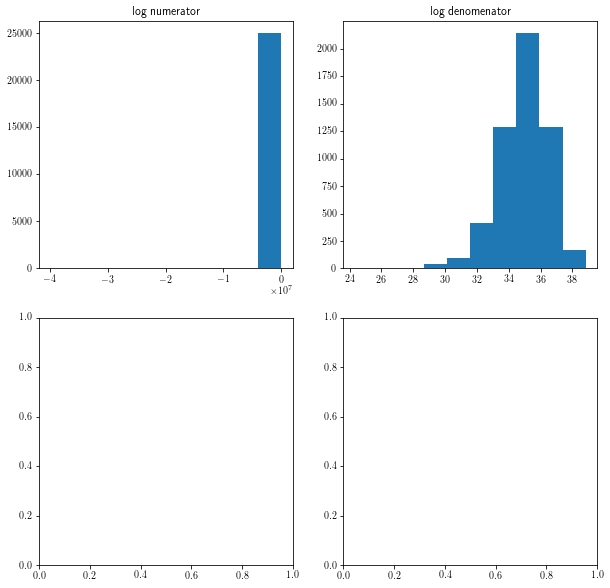

In [20]:
#plt.hist(log_numerator, range=(-10**6,0)) #this is equivalent to plt.hist(log_numerator/(e7), range=(-0.01,0))
# plt.title('log numerator')
MVN_per_point_l_diff = MVN_per_point_l - np.mean(MVN_per_point_l)
log_den = np.log(MVN_per_point_l_diff)
log_den.shape
# plt.hist(log_den)
# plt.title('log denomenator')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].hist(log_numerator); axes[0,0].set_title('log numerator')
axes[0,1].hist(log_den); axes[0,1].set_title('log denomenator')

# axes[1,0].hist(-0.5*np.array(chi2_within_1_sigma[0])); axes[1,0].set_title('log numerator within 1 sigma of best-fit values')
# axes[1,1].hist(np.log(MVG_within_1_sigma[0])); axes[1,1].set_title('log denomenator within 1 sigma of best-fit values')



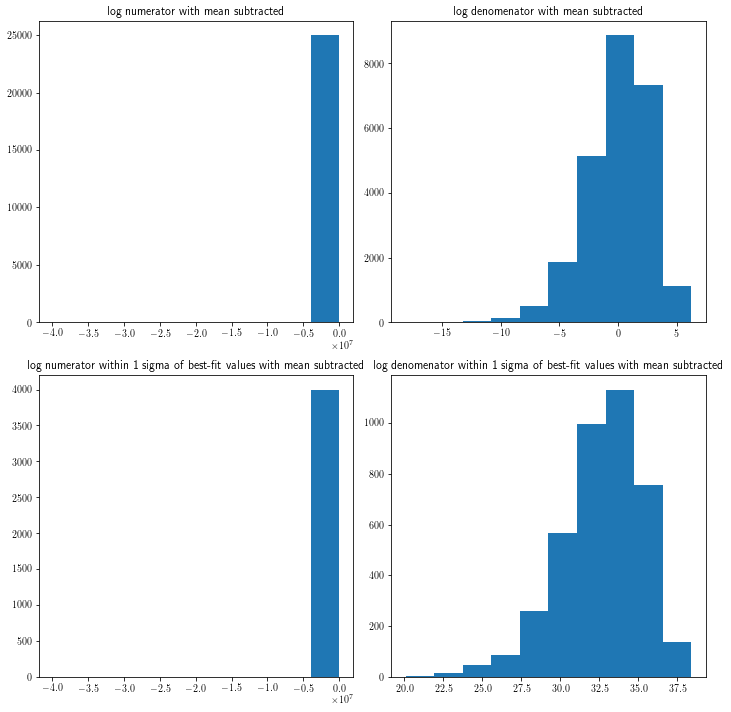

In [30]:
#plt.hist(log_numerator, range=(-10**6,0)) #this is equivalent to plt.hist(log_numerator/(e7), range=(-0.01,0))
# plt.title('log numerator')
log_den = np.log(MVN_per_point_l)
log_den = log_den- np.mean(log_den)


chi2_within_1_sigma[0] = np.array(chi2_within_1_sigma[0]) - np.mean(np.array(chi2_within_1_sigma[0]))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].hist(log_numerator); axes[0,0].set_title('log numerator with mean subtracted')
axes[0,1].hist(log_den); axes[0,1].set_title('log denomenator with mean subtracted')

axes[1,0].hist(-0.5*chi2_within_1_sigma[0]); axes[1,0].set_title('log numerator within 1 sigma of best-fit values with mean subtracted')
axes[1,1].hist(np.log(MVG_within_1_sigma[0])); axes[1,1].set_title('log denomenator within 1 sigma of best-fit values with mean subtracted')

plt.tight_layout()

Text(0.5, 1.0, 'log denomenator')

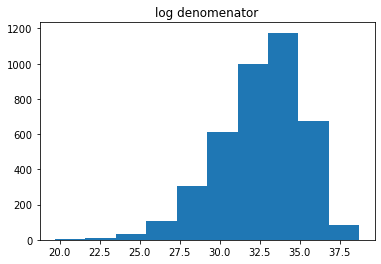

In [60]:
# def log_den(MVN_per_point_l):
#     log_den_l = []
#     for i in range(MVN_per_point_l.shape[0]):
#         log_den = np.log(MVN_per_point_l)



Let's try the weights without doing it in log space

In [116]:
chi2_array_ALL_DATA_25k = chi2_array_ALL_DATA_25k-np.mean(chi2_array_ALL_DATA_25k)
MVN_per_point_l = MVN_per_point_l - np.mean(MVN_per_point_l)
weights = np.exp(-0.5 * chi2_array_ALL_DATA_25k)/MVN_per_point_l
weights

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


array([             inf,             -inf,             -inf, ...,
                    inf,             -inf, -4.44980981e+274],
      dtype=float128)

(array([3999.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ],
       dtype=float128),
 <BarContainer object of 10 artists>)

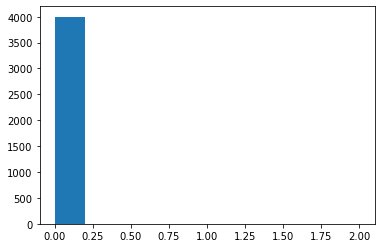

In [114]:
weights = 25k * weights/np.sum(weights)
plt.hist(weights, range=(0,2))

(array([ 1.,  1.,  2.,  1.,  0.,  5.,  4.,  7., 12., 19.]),
 array([-0.01 , -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003,
        -0.002, -0.001,  0.   ], dtype=float128),
 <BarContainer object of 10 artists>)

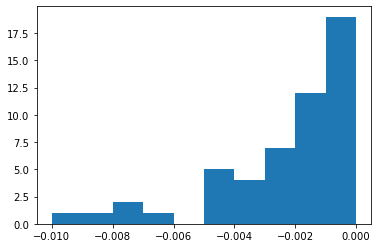

In [61]:
log_RHS = log_numerator - log_den
log_RHS, log_RHS.shape
plt.hist(log_RHS/(1e7), range=(-0.01,0))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.999e+03]),
 array([-8.67315859e+07, -7.80559538e+07, -6.93803216e+07, -6.07046895e+07,
        -5.20290573e+07, -4.33534251e+07, -3.46777930e+07, -2.60021608e+07,
        -1.73265287e+07, -8.65089651e+06,  2.47356437e+04], dtype=float128),
 <BarContainer object of 10 artists>)

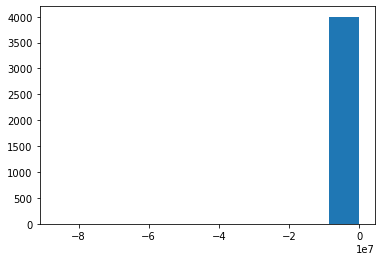

In [62]:
plt.hist(log_RHS)

In [36]:
mean_log_RHS = np.mean(log_RHS)
log_weight =log_RHS- mean_log_RHS
log_weight, log_weight.shape

(array([24068.75203129, 24044.67443657, 24078.10295406, ...,
        20455.39966799, 24123.37242144,   671.34495514], dtype=float128),
 (4000,))

In [41]:
mean_log_RHS

-32.55904404488593718

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.999e+03]),
 array([-8.67315534e+07, -7.80559212e+07, -6.93802891e+07, -6.07046569e+07,
        -5.20290247e+07, -4.33533926e+07, -3.46777604e+07, -2.60021283e+07,
        -1.73264961e+07, -8.65086395e+06,  2.47682028e+04], dtype=float128),
 <BarContainer object of 10 artists>)

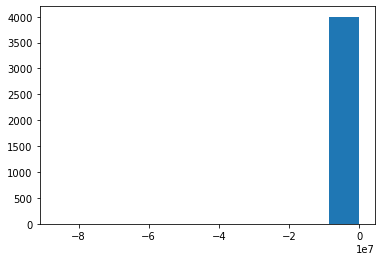

In [37]:
plt.hist(log_weight)

In [38]:
log_weight = MVN_4000_MASTER.shape[0] * log_weight/np.sum(log_weight)
log_weight+

array([8.82129091e+18, 8.81246638e+18, 8.82471806e+18, ...,
       7.49698326e+18, 8.84130949e+18, 2.46050528e+17], dtype=float128)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([inf, inf, inf, ..., inf, inf, inf], dtype=float128)